Random Forest by Mélusine

In [10]:
# Import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [11]:
# Load datas
data = pd.read_csv("cleaned_merged_seasons.csv")

<ipython-input-11-03716eafe93e>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("cleaned_merged_seasons.csv")


In [12]:
print(data.head())

  season_x                name position team_x  assists  bonus  bps  \
0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
4  2016-17        Adam Forshaw      MID    NaN        0      0    3   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      454  ...           2.0     0.0             0   
1             0         0.3      142  ...           1.0     0.0             1   
2             0         4.9       16  ...           3.0    23.0             2   
3             0         0.0      482  ...           1.0     0.0             0   
4             0         1.3      286  ...           1.0     0.0             1   

   transfers_balance  transfers_in transfers_out  value  was_home  \
0                

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [14]:
print(data.describe())

            assists         bonus           bps  clean_sheets    creativity  \
count  96169.000000  96169.000000  96169.000000  96169.000000  96169.000000   
mean       0.041042      0.108715      6.080275      0.106739      4.734000   
std        0.215378      0.492334      9.850595      0.308783     10.689879   
min        0.000000      0.000000    -21.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000     10.000000      0.000000      2.400000   
max        4.000000      3.000000    128.000000      1.000000    170.900000   

            element       fixture  goals_conceded  goals_scored     ict_index  \
count  96169.000000  96169.000000    96169.000000  96169.000000  96169.000000   
mean     327.063264    198.413824        0.495887      0.045514      1.715793   
std      194.313766    108.884200        0.97

In [15]:
# valeurs manquantes
data = data.dropna(subset=['team_x'])

# Normalise
features_to_normalize = ["creativity", "ict_index", "influence", "threat"]
data[features_to_normalize] = data[features_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Encode
data_encoded = pd.get_dummies(data, columns=["season_x", "position", "team_x", "kickoff_time", "opp_team_name"], drop_first=True)

# data type int
data_encoded['was_home'] = data_encoded['was_home'].astype(int)

# Retirer la colonne "name"
player_names = data_encoded['name'].reset_index(drop=True)
data_encoded = data_encoded.drop('name', axis=1)

<ipython-input-15-d8dac73b6c8b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features_to_normalize] = data[features_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [16]:
print(player_names)

0                  Aaron Connolly
1                 Aaron Cresswell
2                      Aaron Mooy
3                  Aaron Ramsdale
4              Abdoulaye Doucouré
                   ...           
76312                Oliver Skipp
76313              Ryan Sessegnon
76314                Ashley Young
76315    Jeremy Sarmiento Morante
76316              Philip Billing
Name: name, Length: 76317, dtype: object


In [17]:
print(data_encoded.head())

       assists  bonus  bps  clean_sheets  creativity  element  fixture  \
19852        0      0   -3             0    0.002203       78        7   
19853        0      0   11             0    0.082232      435        6   
19854        0      0    0             0    0.000000       60        7   
19855        0      0   12             0    0.000000      483        8   
19856        0      0   20             1    0.327460      512        4   

       goals_conceded  goals_scored  ict_index  ...  opp_team_name_Newcastle  \
19852               2             0   0.103659  ...                        0   
19853               2             0   0.067073  ...                        1   
19854               0             0   0.000000  ...                        0   
19855               2             0   0.054878  ...                        0   
19856               0             0   0.210366  ...                        0   

       opp_team_name_Norwich  opp_team_name_Nott'm Forest  \
19852        

In [18]:
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76317 entries, 19852 to 96168
Columns: 882 entries, assists to opp_team_name_Wolves
dtypes: float64(6), int64(25), uint8(851)
memory usage: 80.6 MB
None


In [19]:
print(data_encoded.describe())

            assists         bonus           bps  clean_sheets    creativity  \
count  76317.000000  76317.000000  76317.000000  76317.000000  76317.000000   
mean       0.036178      0.096099      5.387790      0.094553      0.030708   
std        0.202554      0.464405      9.317563      0.292598      0.073637   
min        0.000000      0.000000    -21.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      9.000000      0.000000      0.011747   
max        4.000000      3.000000    128.000000      1.000000      1.000000   

            element       fixture  goals_conceded  goals_scored     ict_index  \
count  76317.000000  76317.000000    76317.000000  76317.000000  76317.000000   
mean     337.943787    199.107381        0.458207      0.040109      0.046101   
std      197.865813    108.770140        0.94

In [20]:
# features (X) et cible (y)
X = data_encoded.copy()

# Ajouter les colonnes 'team_x' et 'position' à X
columns_to_add = ['team_x', 'position']
if all(col in data_encoded.columns for col in columns_to_add):
    X[columns_to_add] = data_encoded[columns_to_add]

# Supprimer la colonne 'total_points' de X
X = X.drop('total_points', axis=1)

# Cible (y)
y = data_encoded['total_points']


In [21]:
# Train-test split
X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(X, y, player_names, test_size=0.2, random_state=42)

In [22]:
print(X_test.columns)

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       ...
       'opp_team_name_Newcastle', 'opp_team_name_Norwich',
       'opp_team_name_Nott'm Forest', 'opp_team_name_Sheffield Utd',
       'opp_team_name_Southampton', 'opp_team_name_Spurs',
       'opp_team_name_Watford', 'opp_team_name_West Brom',
       'opp_team_name_West Ham', 'opp_team_name_Wolves'],
      dtype='object', length=881)


In [23]:
# Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [24]:
# Train
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Prédictions sur l'ensemble de test
predictions = random_forest_model.predict(X_test)

In [26]:

print(predictions)


[1. 2. 0. ... 0. 0. 5.]


In [27]:
player_names_test = player_names_test.reset_index(drop=True)

In [28]:
results_df = pd.DataFrame({'Name': player_names_test, 'Predicted_Total_Points': predictions})

print(results_df)


                    Name  Predicted_Total_Points
0           Daniel James                     1.0
1           Nicolas Pépé                     2.0
2             Sam Waller                     0.0
3             Bernd Leno                     0.0
4       Ezri Konsa Ngoyo                     6.0
...                  ...                     ...
15259  Aaron Wan-Bissaka                     0.0
15260       Divock Origi                     0.0
15261   Joseph Whitworth                     0.0
15262       Alex Mighten                     0.0
15263  Christian Pulisic                     5.0

[15264 rows x 2 columns]


In [29]:
# performances
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE) on Test Set: {mae}')
print(f'R-squared on Test Set: {r2}')

Mean Absolute Error (MAE) on Test Set: 0.031267033542976934
R-squared on Test Set: 0.9921837594764341


Mean Absolute Error (MAE): Une valeur de MAE aussi basse (0.031) indique que les prédictions du modèle sont en moyenne très proches des valeurs réelles.

R-squared (R2): Une valeur de R-squared aussi élevée (0.992) suggère que votre modèle explique très bien la variance des données de test. En d'autres termes, environ 99.2% de la variance de la variable dépendante (total_points) est expliquée par votre modèle.

In [30]:
from sklearn.model_selection import cross_val_score

# Effectuer la validation croisée
cross_val_scores = cross_val_score(random_forest_model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Calculer la moyenne des scores
average_mae = -cross_val_scores.mean()

# Afficher les résultats
print(f'Average Cross-Validated Mean Absolute Error: {average_mae}')

Average Cross-Validated Mean Absolute Error: 0.027796799839391817


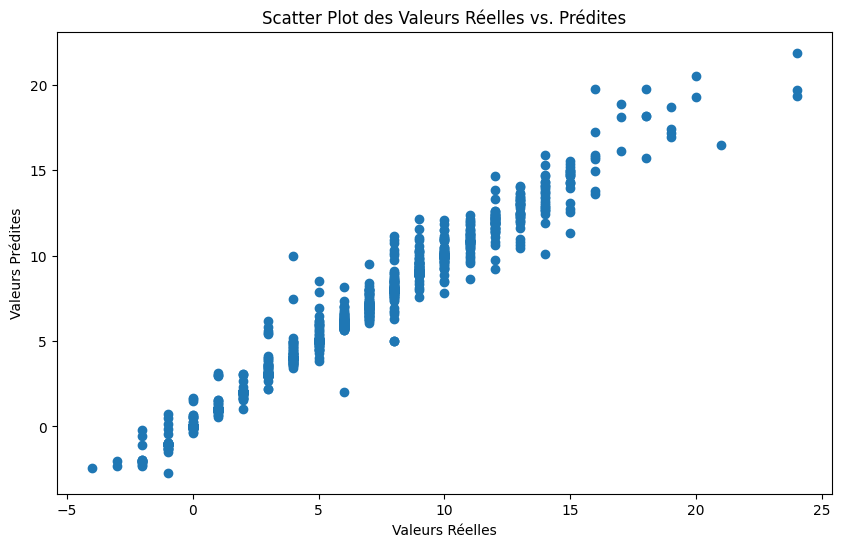

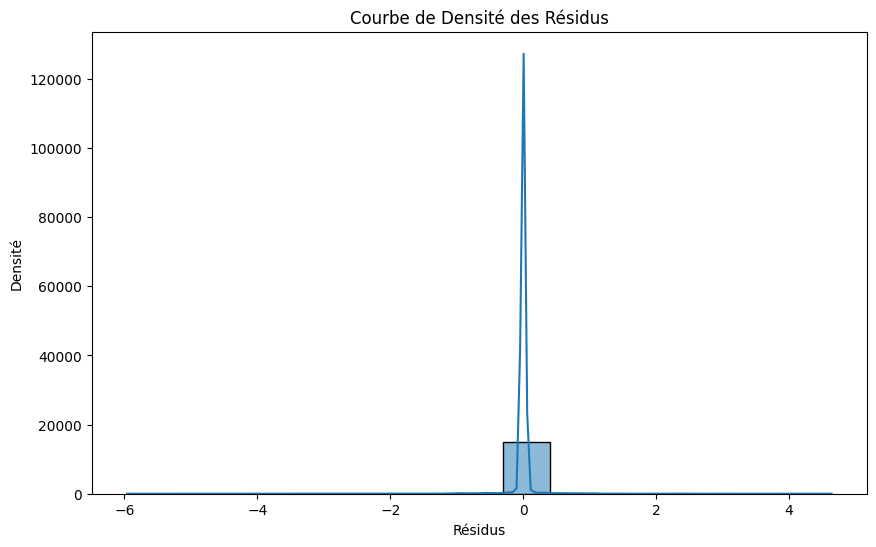

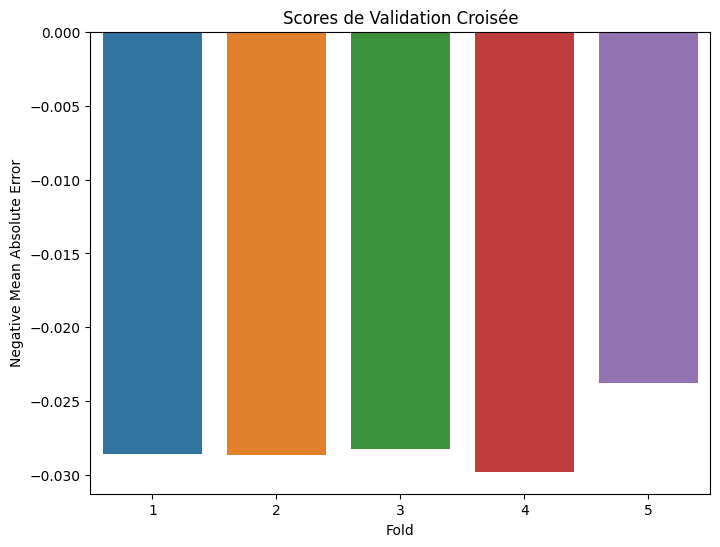

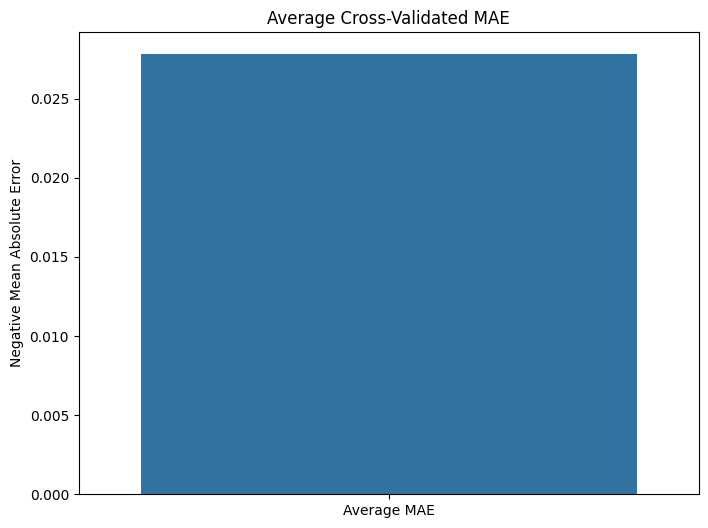

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict

# Prédictions sur l'ensemble de test
y_pred = random_forest_model.predict(X_test)

# Scatter plot des valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.show()

# Plot des résidus
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Courbe de Densité des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.show()

# Graphique pour cross_val_scores
plt.figure(figsize=(8, 6))
sns.barplot(x=list(range(1, 6)), y=cross_val_scores)
plt.title('Scores de Validation Croisée')
plt.xlabel('Fold')
plt.ylabel('Negative Mean Absolute Error')
plt.show()

# Graphique pour average_mae
plt.figure(figsize=(8, 6))
sns.barplot(x=['Average MAE'], y=[average_mae])
plt.title('Average Cross-Validated MAE')
plt.ylabel('Negative Mean Absolute Error')
plt.show()


L'obtention d'un "Average Cross-Validated Mean Absolute Error" aussi bas (0.0278) confirme la robustesse de votre modèle, même après avoir été évalué sur plusieurs plis de validation croisée. Une valeur de MAE aussi basse indique que votre modèle est capable de faire des prédictions précises et cohérentes sur des données non vues.

Vous avez donc un modèle qui semble bien généraliser et maintenir sa performance sur différentes portions des données d'entraînement. Cela renforce la confiance dans la capacité du modèle à être efficace lorsqu'il est déployé sur de nouvelles données.